In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
%matplotlib inline
import random
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras import backend as K

seed = 21
random.seed = seed
np.random.seed = seed

In [2]:
clear_frames = 'sharp dataset'
bad_frames = 'noisy dataset'

In [3]:
clean_frames = []
for file in tqdm(sorted(os.listdir(clear_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(clear_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        clean_frames.append(image)

clean_frames = np.array(clean_frames)
blurry_frames = []
for file in tqdm(sorted(os.listdir(bad_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

100%|███████████████████████████████████████████████████████████████████████████████| 171/171 [00:01<00:00, 151.15it/s]


In [4]:
class_names = ['noisy dataset','sharp dataset']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (128,128)

In [5]:
 #C:\Users\onlin\Downloads\archive\dataset
def load_data():

    datasets = ['C:/Users/tdpra/Music/IMG QUAL/dataset/train', 'C:/Users/tdpra/Music/IMG QUAL/dataset/test']

    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the images and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output   

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Users/tdpra/Music/IMG QUAL/dataset/train


100%|███████████████████████████████████████████████████████████████████████████████| 171/171 [00:01<00:00, 130.60it/s]


Loading C:/Users/tdpra/Music/IMG QUAL/dataset/test


100%|███████████████████████████████████████████████████████████████████████████████| 171/171 [00:01<00:00, 126.73it/s]


74


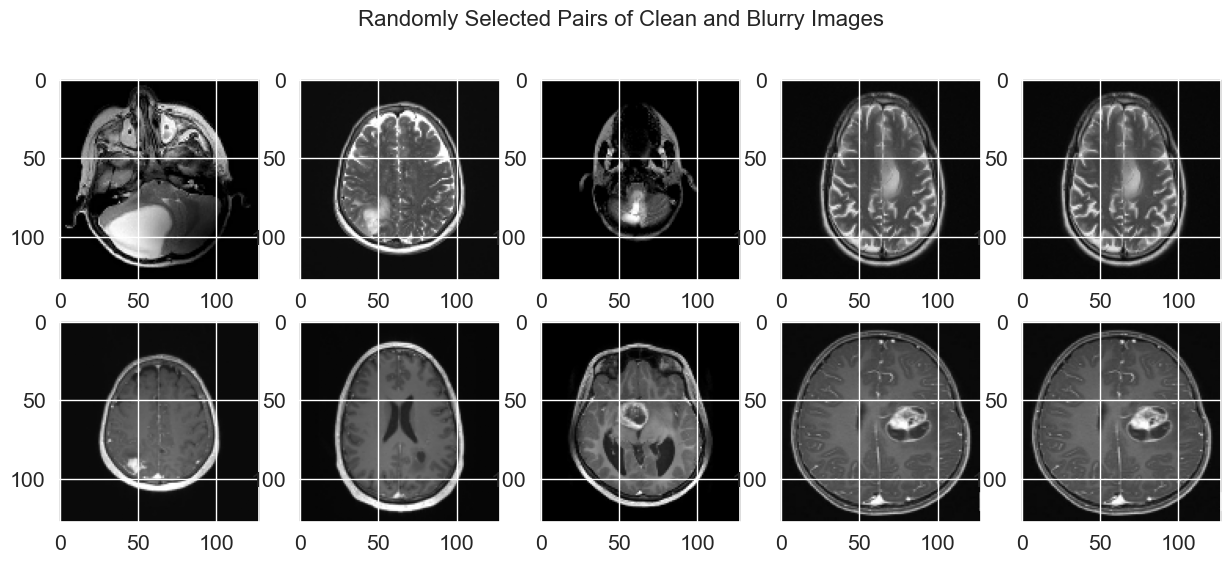

In [7]:
import random

# Create a list to store the indices of selected pairs
selected_indices = []

# Generate 5 random integers
for _ in range(5):
    selected_indices.append(random.randint(0, len(clean_frames)-1))

# Create figure and subplots for each pair
fig = plt.figure(figsize=(15, 6))
fig.suptitle('Randomly Selected Pairs of Clean and Blurry Images', fontsize=16)
# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.1, wspace=0.2)

# Loop through selected indices and display corresponding pairs of images
for i, idx in enumerate(selected_indices, start=1):
    ax = fig.add_subplot(2, 5, i)
    ax.imshow(clean_frames[idx])
    ax = fig.add_subplot(2, 5, i+5)
    ax.imshow(blurry_frames[idx])
    
print(idx)

plt.show()


In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 404
Number of testing examples: 404
Each image is of size: (128, 128)


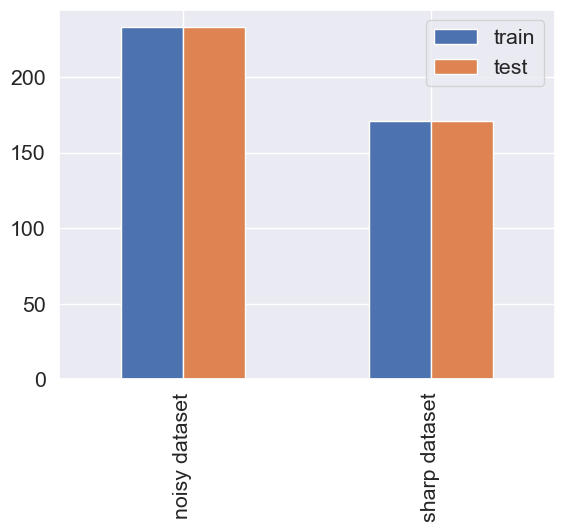

In [9]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [11]:
def display_examples(class_names, images, labels):


    fig = plt.figure(figsize=(10,10))
    fig.suptitle("images of the dataset", fontsize=16)
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

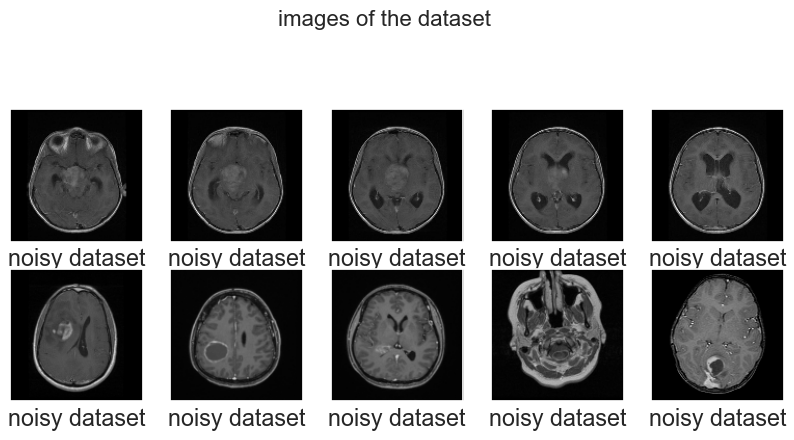

In [12]:
display_examples(class_names, train_images, train_labels)


In [13]:
# Network Parameters
input_shape = (128,128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]

In [14]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

In [15]:
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [16]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 latent_vector (Dense)       (None, 256)               16777472  
                                                                 
Total params: 17148288 (65.42 MB)
Trainable params: 1714828

In [17]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [18]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 65536)             16842752  
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       590080    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 128, 128, 64)      7379

In [19]:
model = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 256)               17148288  
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       17803395  
                                                                 
Total params: 34951683 (133.33 MB)
Trainable params: 34951683 (133.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer='adam',metrics=["acc"])

In [24]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [25]:
callbacks = [lr_reducer]
history = model.fit(blurry_frames,
                      clean_frames,
                      validation_data=(blurry_frames, clean_frames),
                      epochs=50,
                      batch_size=batch_size,
                      callbacks=callbacks)
# After training, obtain the final latent vectors for a set of input images
final_latent_vectors = encoder.predict(blurry_frames)

# Display the final latent vectors
print("Final Latent Vectors:")
print(final_latent_vectors)

Epoch 1/50
6/6 [==============================] - 12s 2s/step - loss: 0.1495 - acc: 0.6430 - val_loss: 0.1444 - val_acc: 0.7500 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 8s 1s/step - loss: 0.1196 - acc: 0.7432 - val_loss: 0.0494 - val_acc: 0.7233 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - 8s 1s/step - loss: 0.0386 - acc: 0.6593 - val_loss: 0.0324 - val_acc: 0.5567 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - 9s 2s/step - loss: 0.0318 - acc: 0.5850 - val_loss: 0.0292 - val_acc: 0.6478 - lr: 0.0010
Epoch 5/50
6/6 [==============================] - 9s 1s/step - loss: 0.0292 - acc: 0.6733 - val_loss: 0.0274 - val_acc: 0.6186 - lr: 0.0010
Epoch 6/50
6/6 [==============================] - 9s 1s/step - loss: 0.0273 - acc: 0.5491 - val_loss: 0.0267 - val_acc: 0.5090 - lr: 0.0010
Epoch 7/50
6/6 [==============================] - 9s 2s/step - loss: 0.0265 - acc: 0.5176 - val_loss: 0.0268 - val_acc: 0.5131 - lr: 0.0010
Epoch 8/50
6/6 [===

1/1 [==============================] - 0s 61ms/step


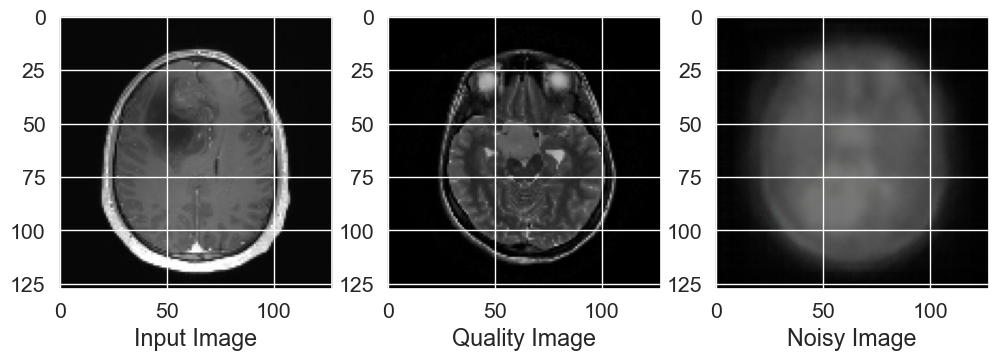

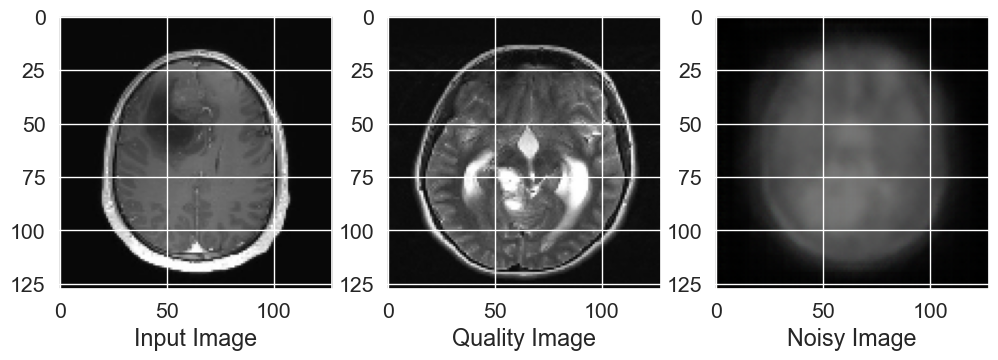

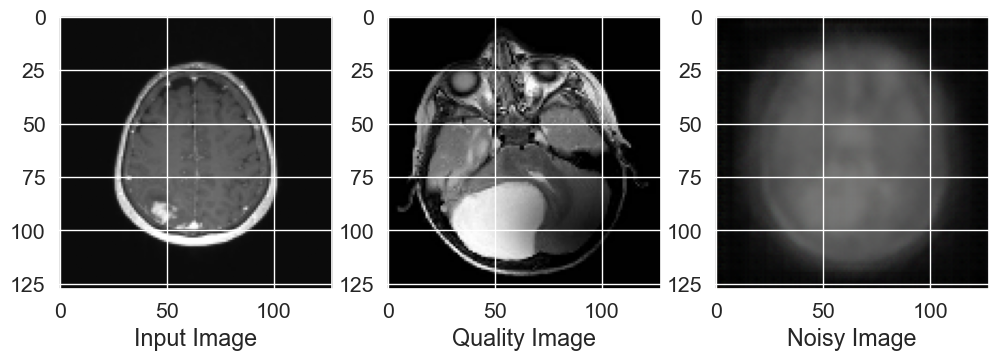

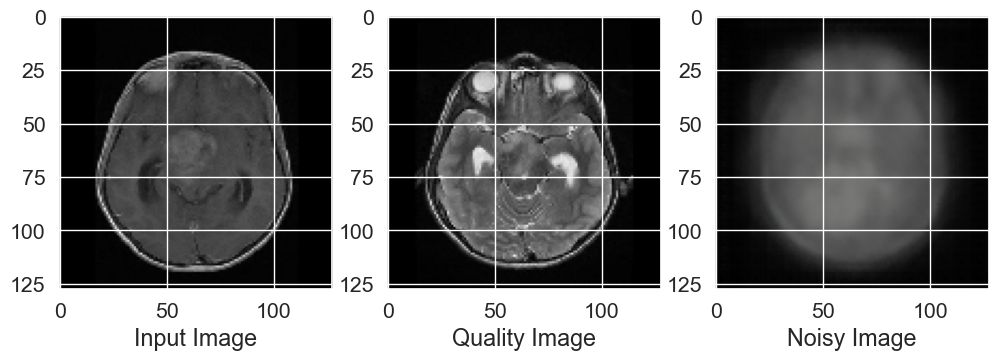

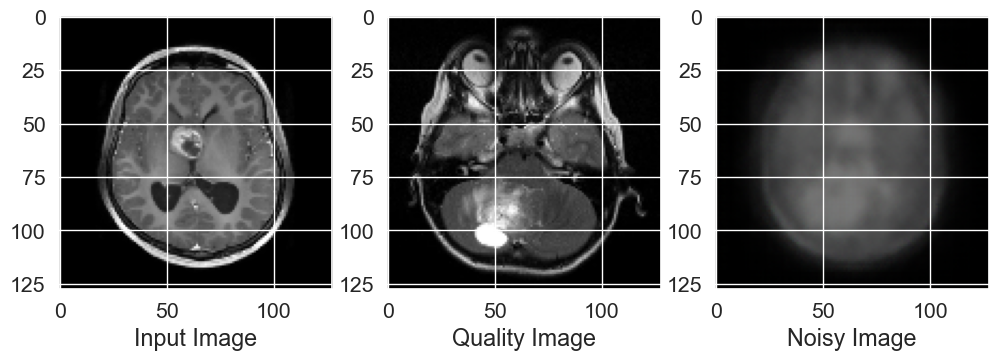

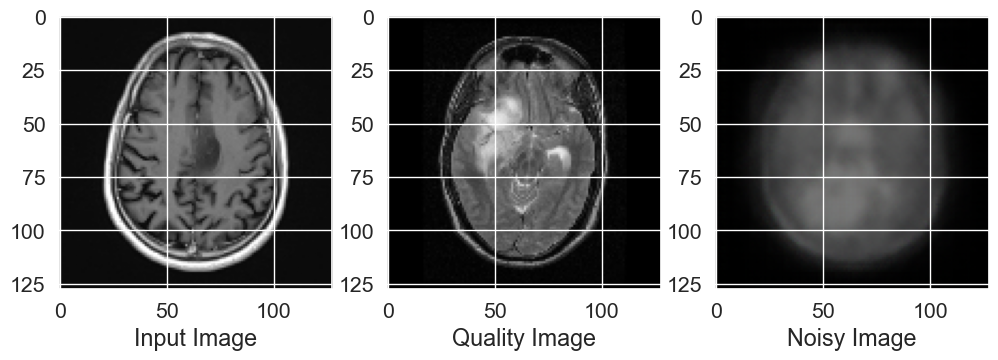

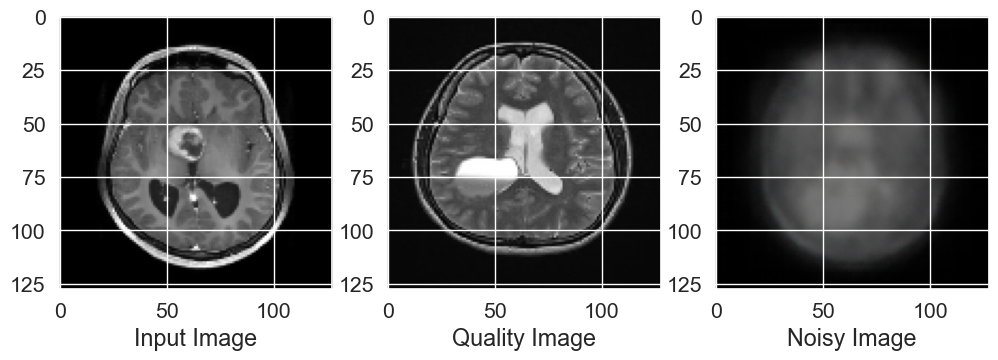

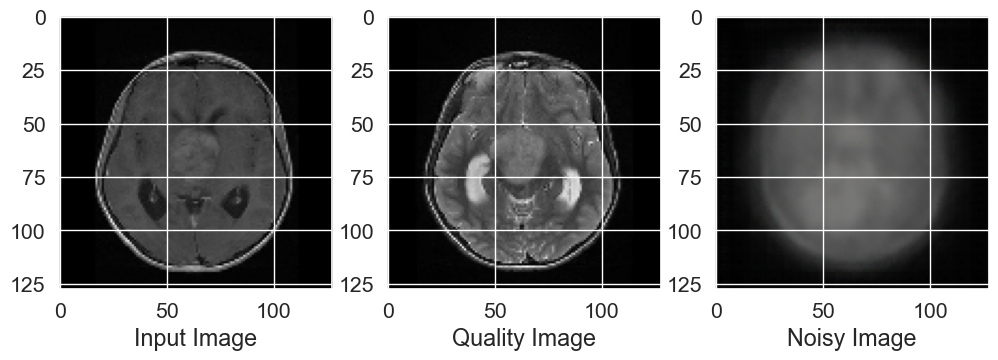

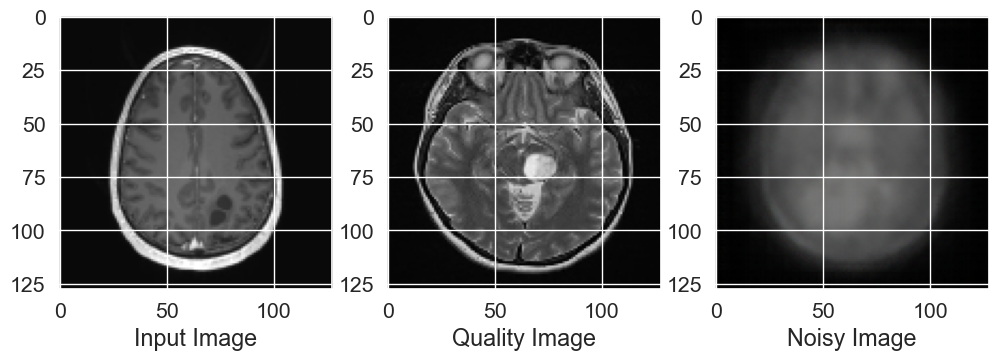

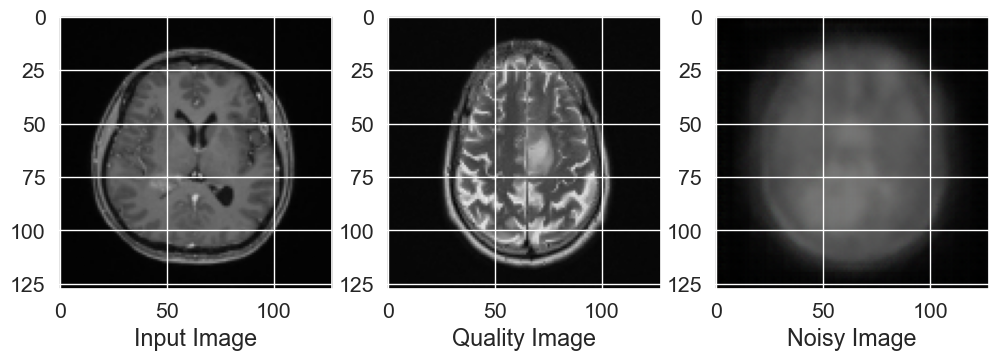

In [26]:

for i in range(10):
    
    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp=x.reshape(1,128,128,3)
    result = model.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)
    ax.set_xlabel('Input Image')

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)
    ax.set_xlabel('Quality Image')

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)
    ax.set_xlabel('Noisy Image')
    


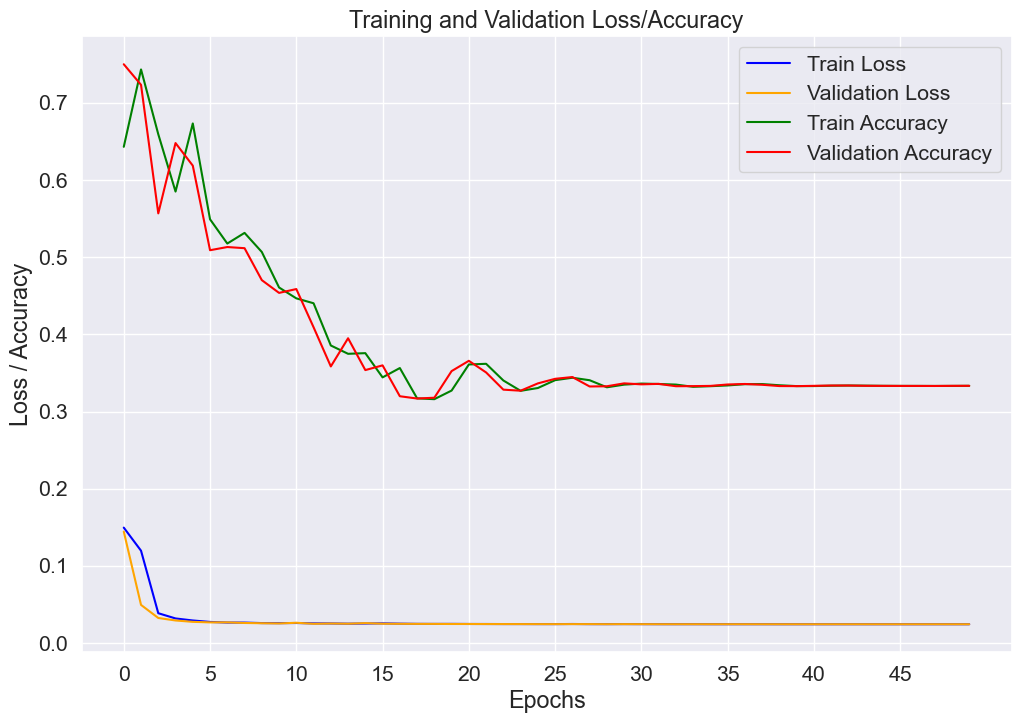

In [28]:

# Final loss and accuracy values
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_acc = history.history['acc'][-1]
final_val_acc = history.history['val_acc'][-1]

# Calculating loss and accuracy percentages
final_loss_percentage = final_loss * 100
final_val_loss_percentage = final_val_loss * 100
final_acc_percentage = final_acc * 100
final_val_acc_percentage = final_val_acc * 100

# Plotting loss and accuracy
plt.figure(figsize=(12, 8))

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

# Plotting accuracy
plt.plot(history.history['acc'], label='Train Accuracy', color='green')
plt.plot(history.history['val_acc'], label='Validation Accuracy', color='red')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Loss/Accuracy')
plt.legend()

# Setting x-axis ticks
plt.xticks(np.arange(0, len(history.history['loss']), step=5))

plt.show()



In [29]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Assuming clean_frames and blurry_frames are your images
num_images_to_process = 10  # Number of images to process

# Calculate PSNR, SSIM, and MSE for each image
psnr_values = [psnr(clean_frames[i], blurry_frames[i]) for i in range(num_images_to_process)]
mse_values = [mean_squared_error(clean_frames[i], blurry_frames[i]) for i in range(num_images_to_process)]

# Calculate CNR (assuming grayscale images)
mean_clean = np.mean(clean_frames[:num_images_to_process], axis=(1, 2, 3))
mean_blurry = np.mean(blurry_frames[:num_images_to_process], axis=(1, 2, 3))
std_clean = np.std(clean_frames[:num_images_to_process], axis=(1, 2, 3))
std_blurry = np.std(blurry_frames[:num_images_to_process], axis=(1, 2, 3))
cnr_values = np.abs(mean_clean - mean_blurry) / np.sqrt((std_clean ** 2 + std_blurry ** 2) / 2)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'PSNR': psnr_values,
    'MSE': mse_values,
    'CNR': cnr_values
})

print(metrics_df)



        PSNR       MSE       CNR
0  15.307131  0.029464  0.153933
1  16.974710  0.020069  0.220428
2  18.056164  0.015645  0.211337
3  17.600845  0.017375  0.178192
4  17.189322  0.019102  0.085381
5  16.831254  0.020743  0.177787
6  15.418454  0.028718  0.347060
7  16.338552  0.023235  0.083741
8  16.050610  0.024828  0.280948
9  15.398601  0.028850  0.048845


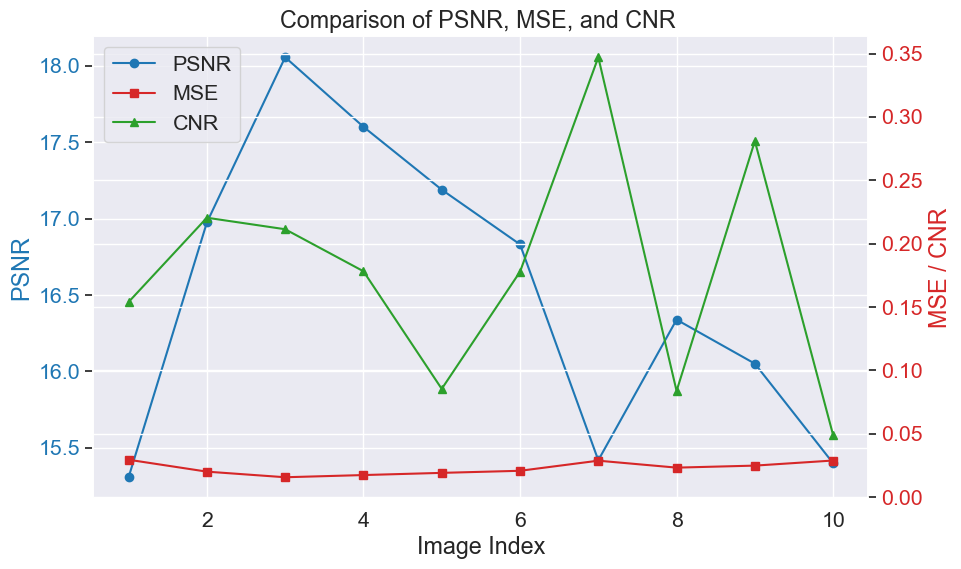

In [30]:
import matplotlib.pyplot as plt

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot PSNR on the first y-axis
ax1.plot(range(1, 11), psnr_values, marker='o', color='tab:blue', label='PSNR')
ax1.set_xlabel('Image Index')
ax1.set_ylabel('PSNR', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for MSE and CNR
ax2 = ax1.twinx()

# Plot MSE and CNR on the second y-axis
ax2.plot(range(1, 11), mse_values, marker='s', color='tab:red', label='MSE')
ax2.plot(range(1, 11), cnr_values, marker='^', color='tab:green', label='CNR')
ax2.set_ylabel('MSE / CNR', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

# Title and grid
plt.title('Comparison of PSNR, MSE, and CNR ')
plt.grid(True)

plt.show()




In [31]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])


In [32]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])





In [33]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=11, validation_split = 0.2)

Epoch 1/11
3/3 [==============================] - 3s 460ms/step - loss: 1.5609 - accuracy: 0.7214 - val_loss: 0.1682 - val_accuracy: 1.0000
Epoch 2/11
3/3 [==============================] - 1s 324ms/step - loss: 0.9480 - accuracy: 0.3777 - val_loss: 1.2743 - val_accuracy: 0.0123
Epoch 3/11
3/3 [==============================] - 1s 314ms/step - loss: 0.5660 - accuracy: 0.7214 - val_loss: 1.5551 - val_accuracy: 0.0000e+00
Epoch 4/11
3/3 [==============================] - 1s 300ms/step - loss: 0.5291 - accuracy: 0.7214 - val_loss: 0.9140 - val_accuracy: 0.0494
Epoch 5/11
3/3 [==============================] - 1s 320ms/step - loss: 0.4832 - accuracy: 0.8142 - val_loss: 0.7998 - val_accuracy: 0.3086
Epoch 6/11
3/3 [==============================] - 1s 340ms/step - loss: 0.4135 - accuracy: 0.8266 - val_loss: 0.8131 - val_accuracy: 0.3704
Epoch 7/11
3/3 [==============================] - 1s 328ms/step - loss: 0.3220 - accuracy: 0.9164 - val_loss: 0.6625 - val_accuracy: 0.6173
Epoch 8/11
3/3 [

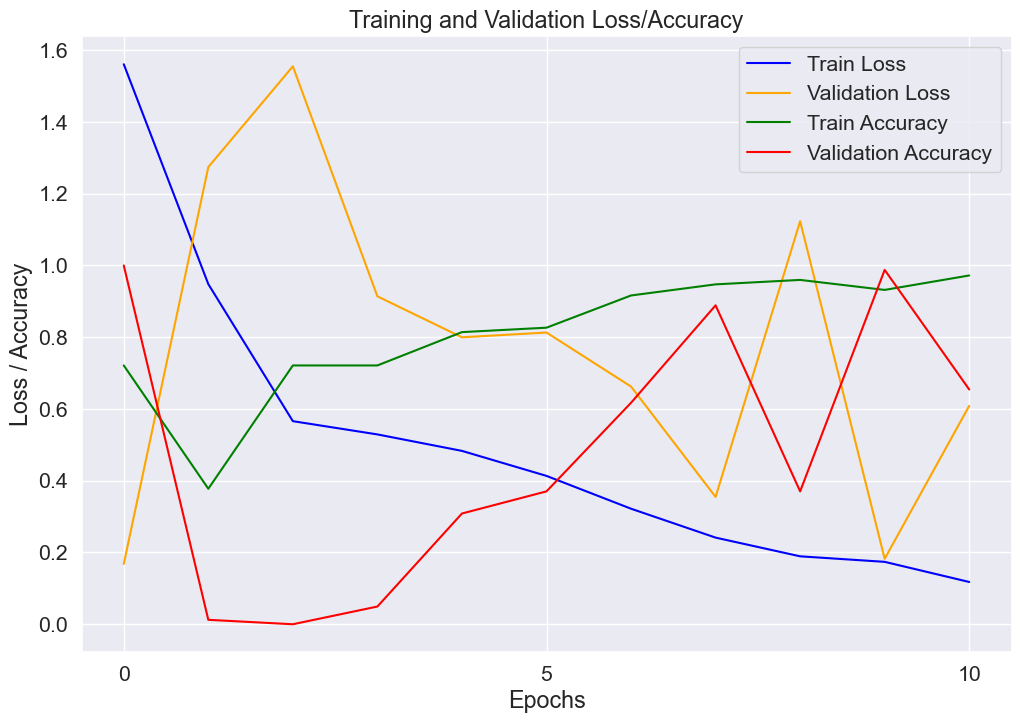

Final Loss: 11.78%
Final Validation Loss: 60.88%
Final Accuracy: 97.21%
Final Validation Accuracy: 65.43%


In [35]:
# Final loss and accuracy values
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

# Calculating loss and accuracy percentages
final_loss_percentage = final_loss * 100
final_val_loss_percentage = final_val_loss * 100
final_acc_percentage = final_acc * 100
final_val_acc_percentage = final_val_acc * 100

# Plotting loss and accuracy
plt.figure(figsize=(12, 8))

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Loss/Accuracy')
plt.legend()

# Setting x-axis ticks
plt.xticks(np.arange(0, len(history.history['loss']), step=5))

plt.show()

# Printing loss and accuracy percentages
print("Final Loss: {:.2f}%".format(final_loss_percentage))
print("Final Validation Loss: {:.2f}%".format(final_val_loss_percentage))
print("Final Accuracy: {:.2f}%".format(final_acc_percentage))
print("Final Validation Accuracy: {:.2f}%".format(final_val_acc_percentage))


